# We will solve the Simple Harmonic equation here
$$
\frac{d^2 }{dx^2}y(x)+5y(x)=0
$$
for the boundary conditions $y(0)=1$

In [94]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# LEts start by defining the domain in which I want the solution of this differntial equation
x = torch.tensor(np.linspace(0,20,10),requires_grad=True)
x = x.float()
print(x)
x_input = x.unsqueeze(dim=1)

x_input.requires_grad_(True)
print(x_input)

tensor([ 0.0000,  2.2222,  4.4444,  6.6667,  8.8889, 11.1111, 13.3333, 15.5556,
        17.7778, 20.0000], grad_fn=<ToCopyBackward0>)
tensor([[ 0.0000],
        [ 2.2222],
        [ 4.4444],
        [ 6.6667],
        [ 8.8889],
        [11.1111],
        [13.3333],
        [15.5556],
        [17.7778],
        [20.0000]], grad_fn=<UnsqueezeBackward0>)


## Now I will define neural network and everything else will follow accordingly

In [95]:
class PINN(nn.Module):
    def __init__(self, in_layer = int, out_layer = int, num_of_layer = int, hidden_size = int):
        super().__init__()
        self.input_layer = nn.Linear(in_layer, hidden_size)
        self.activation = nn.Tanh() # For smooth derivatives

        # Creating scalable model
        hidden_layer = []
        for _ in range(num_of_layer-1):
            hidden_layer.append(nn.Linear(in_features = hidden_size, out_features = hidden_size))
            hidden_layer.append(nn.Tanh())
        
        # Registering the list of layers as module list
        self.hidden_stack = nn.ModuleList(hidden_layer)


        #Defining the output layer
        self.output_layer = nn.Linear(hidden_size, out_layer)
    

    #Forward pass
    def forward(self, x: torch.tensor):
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_stack:
            x = layer(x)

        x = self.output_layer(x)
        return x


In [110]:
# Let's see if the code is working
torch.manual_seed(10)

# Creating an instance of our neural network
my_first_model = PINN(1,1,5,20)



y_preds = my_first_model(x_input)

In [111]:
print(y_preds)

tensor([[0.0318],
        [0.0320],
        [0.0455],
        [0.0540],
        [0.0585],
        [0.0612],
        [0.0630],
        [0.0641],
        [0.0646],
        [0.0647]], grad_fn=<AddmmBackward0>)


# Moving towards loss function

In [7]:
dy_dx = torch.autograd.grad(outputs=y_preds, inputs= x_input, grad_outputs= torch.ones_like(y_preds), create_graph= True)[0]
print(dy_dx)

tensor([[-6.4031e-03],
        [-1.9148e-03],
        [ 1.0744e-03],
        [ 7.2771e-04],
        [ 4.5516e-04],
        [ 2.9316e-04],
        [ 1.8107e-04],
        [ 1.0700e-04],
        [ 6.1373e-05],
        [ 3.4559e-05]], grad_fn=<MmBackward0>)


In [8]:
d2y_dx2 = torch.autograd.grad(outputs= dy_dx, inputs= x_input, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
print(d2y_dx2)

tensor([[-7.7948e-03],
        [ 3.5722e-03],
        [ 1.9459e-05],
        [-1.6751e-04],
        [-8.9226e-05],
        [-6.0244e-05],
        [-4.1249e-05],
        [-2.6159e-05],
        [-1.5647e-05],
        [-9.0348e-06]], grad_fn=<MmBackward0>)


Now at this point I am only left with one last ingredient to create the loss function. The boundary conditions. Since, boundary condition of the form
$$
\mathcal{L}_{BC} = ||y_{pred}|_{x=0}-y_{constant}|_{x=0}||^2
$$
This means I need another tensor which is the point x=0

In [73]:
# This is the boundary point
x_bc = torch.tensor(0.0, requires_grad = False).unsqueeze(dim=-1)

# Similarly I need to setup the y point which has a constant value
y_bc = torch.tensor(1.0, requires_grad = False)

# I understand that I need to output the value of network at the pont x_bc which should always be equal to y_bc

y_pred_bc = my_first_model

In [74]:
y_pred_bc = my_first_model(x_bc)
print(y_pred_bc)

tensor([-0.0206], grad_fn=<ViewBackward0>)


# Let's create loss function

The first loss if of the differential equation

In [75]:
loss_diff_eq = torch.mean((d2y_dx2+5*y_preds)**2)
print(loss_diff_eq)

tensor(0.0100, grad_fn=<MeanBackward0>)


Now I have to define the loss of the boundary condition

In [12]:
loss_bc = (y_pred_bc-y_bc)
# print(loss_bc)

Hence the total loss is given by

In [13]:
total_loss = loss_diff_eq + loss_bc
print(total_loss)

tensor([-0.9390], grad_fn=<AddBackward0>)


I have to choose an optimiser as well

In [ ]:
optimizer = torch.optim.Adam(params=my_first_model.parameters(),lr=0.001)

# Time to train the neural network

In [113]:
# Hyper parameters
epochs = 10000
epoch_count = []
loss_track = []


for i in range(epochs):
    # Putting the model in training mode
    my_first_model.train()

    y_preds = my_first_model(x_input)
    # Calculating the derivative d2y_dx2
    dy_dx = torch.autograd.grad(outputs=y_preds, inputs= x_input, grad_outputs= torch.ones_like(y_preds), create_graph= True)[0]
    # and finally
    d2y_dx2 = torch.autograd.grad(outputs= dy_dx, inputs= x_input, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
    # Caluclating the y at the boundary value

    y_pred_bc = my_first_model(x_bc)
    # SO the loss is to be define here then
    loss_diff_eq = torch.mean((d2y_dx2+5*y_preds)**2) 
    loss_bc = (y_pred_bc-y_bc)**2

    total_loss = loss_diff_eq + loss_bc


    # Setting the gradients to zero
    optimizer.zero_grad()

    # Calculating the backward pass
    total_loss.backward()

    # Updating the model
    optimizer.step()

    if i % 100==0:
        epoch_count.append(i)
        loss_track.append(total_loss.detach().numpy())
        print(f"Epoch: {i}  | Total loss: {total_loss.detach().numpy()}")

Epoch: 0  | Total loss: [1.0144316]
Epoch: 100  | Total loss: [0.00200118]
Epoch: 200  | Total loss: [3.94711e-05]
Epoch: 300  | Total loss: [2.2506374e-05]
Epoch: 400  | Total loss: [1.2553251e-05]
Epoch: 500  | Total loss: [6.844591e-06]
Epoch: 600  | Total loss: [3.6991094e-06]
Epoch: 700  | Total loss: [2.0678347e-06]
Epoch: 800  | Total loss: [1.2777198e-06]
Epoch: 900  | Total loss: [9.141613e-07]
Epoch: 1000  | Total loss: [0.00258687]
Epoch: 1100  | Total loss: [4.9120426e-06]
Epoch: 1200  | Total loss: [1.7052471e-06]
Epoch: 1300  | Total loss: [3.6655358e-06]
Epoch: 1400  | Total loss: [5.8145833e-06]
Epoch: 1500  | Total loss: [5.053242e-07]
Epoch: 1600  | Total loss: [9.3623385e-05]
Epoch: 1700  | Total loss: [5.8890885e-07]
Epoch: 1800  | Total loss: [3.3192198e-06]
Epoch: 1900  | Total loss: [9.130246e-06]
Epoch: 2000  | Total loss: [1.0731127e-07]
Epoch: 2100  | Total loss: [0.00073344]
Epoch: 2200  | Total loss: [1.5176474e-07]
Epoch: 2300  | Total loss: [4.551071e-08]


In [92]:
print(total_loss)
total_loss.detach().numpy()

tensor(0.9702, grad_fn=<AddBackward0>)


array(0.9702431, dtype=float32)

In [84]:
my_first_model.train()

y_preds = my_first_model(x_input)

In [85]:
dy_dx = torch.autograd.grad(outputs=y_preds, inputs= x_input, grad_outputs= torch.ones_like(y_preds), create_graph= True)[0]
    # and finally
d2y_dx2 = torch.autograd.grad(outputs= dy_dx, inputs= x_input, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]

In [86]:
loss_diff_eq = torch.mean((d2y_dx2+5*y_preds)**2) 
y_pred_bc = my_first_model(x_bc)
loss_bc = torch.mean((y_pred_bc-y_bc)**2)

total_loss = loss_diff_eq + loss_bc
print(total_loss)

tensor(0.9702, grad_fn=<AddBackward0>)


In [87]:
optimizer.zero_grad()

In [88]:
total_loss.backward()

In [89]:
optimizer.step()

In [91]:
(d2y_dx2+5*y_preds)**2

tensor([[0.0344],
        [0.0166],
        [0.0164],
        [0.0191],
        [0.0209],
        [0.0221],
        [0.0229],
        [0.0234],
        [0.0237],
        [0.0238]], grad_fn=<PowBackward0>)

In [92]:
(y_pred_bc-y_bc)**2

tensor([0.9242], grad_fn=<PowBackward0>)

In [55]:
my_first_model.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[ 0.7645],
                      [ 0.8300],
                      [-0.2343],
                      [ 0.9186],
                      [-0.2191],
                      [ 0.2018],
                      [-0.4869],
                      [ 0.5873],
                      [ 0.8815],
                      [-0.7336],
                      [ 0.8692],
                      [ 0.1872],
                      [ 0.7388],
                      [ 0.1354],
                      [ 0.4822],
                      [-0.1412],
                      [ 0.7709],
                      [ 0.1478],
                      [-0.4668],
                      [ 0.2549]])),
             ('input_layer.bias',
              tensor([-0.4607, -0.1173, -0.4062,  0.6634, -0.7894, -0.4610, -0.2824, -0.6013,
                       0.0944, -0.9877,  0.9031, -0.8495,  0.7720,  0.1664, -0.3247,  0.6179,
                       0.1559,  0.8080,  0.1093, -0.3154])),
             ('hid

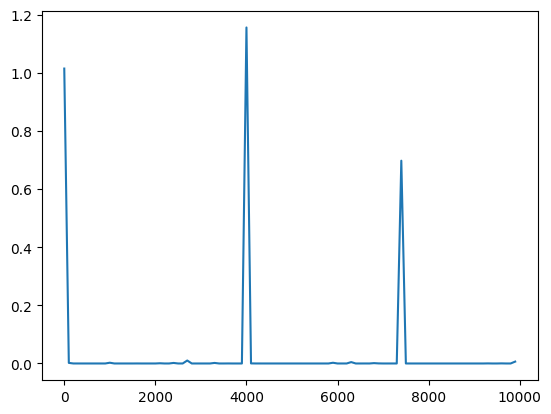

In [114]:
plt.plot(epoch_count, loss_track)

In [ ]:
validation_points = torch.tensor(np.linspace(), requires)